# Tackling distributions

#### Ideas
add run/pass yards given up

In [1]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math

In [2]:
year = 2022

### Play-By-Play data for 2022
df_pbp = nfl.import_pbp_data(years=[year])

### Players
df_players = nfl.import_rosters([year])
### Teams
df_teams = nfl.import_team_desc()

2022 done.
Downcasting floats.


## Solo tackles

In [3]:
df_solo_tackles = df_pbp[df_pbp['solo_tackle']==1.]

In [4]:
df_solo_tackles = df_solo_tackles.merge(df_players[["player_id", "player_name", "position", "team"]], left_on="solo_tackle_1_player_id", right_on="player_id")
df_solo_tackles = df_solo_tackles.merge(df_teams[["team_abbr", "team_color"]], left_on="team", right_on="team_abbr")

In [5]:
df_solo_tackles.groupby('player_name')['player_name'].count().sort_values()

player_name
Joe Flacco                     1
Demetrius Flannigan-Fowles     1
Matt Ryan                      1
Demarcus Robinson              1
Josh Ross                      1
                              ..
L'Jarius Sneed                19
Roger McCreary                19
Zaire Franklin                20
Chidobe Awuzie                20
Pete Werner                   24
Name: player_name, Length: 770, dtype: int64

In [6]:
df_team_tackles = df_solo_tackles.groupby('team')['team'].count().reset_index(name='total_solo_tackles')
df_team_tackles = df_team_tackles.merge(df_teams[["team_abbr", "team_color"]], left_on="team", right_on="team_abbr")

## Tackles per position group

In [7]:
dl_tackles = np.count_nonzero(df_solo_tackles['position']=='DL')
lb_tackles = np.count_nonzero(df_solo_tackles['position']=='LB')
db_tackles = np.count_nonzero(df_solo_tackles['position']=='DB')

In [8]:
labels = ['DL','LB', 'DB']
values = [dl_tackles, lb_tackles, db_tackles]

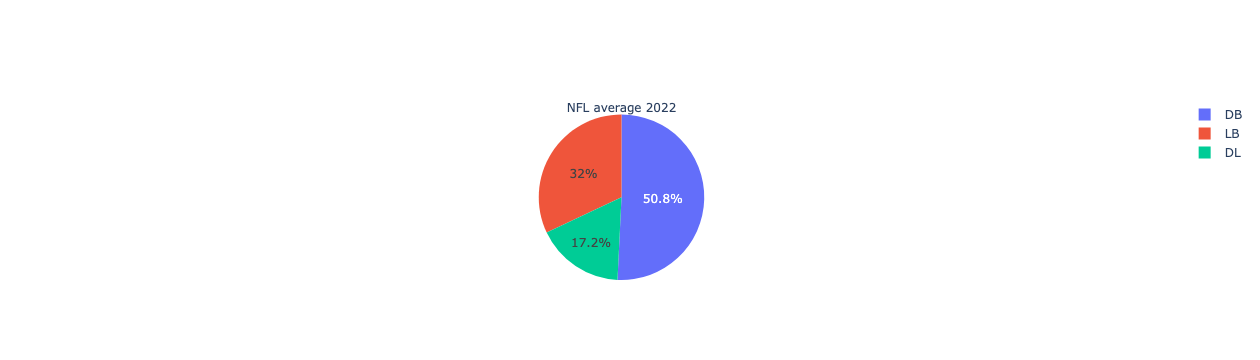

In [9]:
fig = go.Figure(data=[go.Pie(labels=labels, values=values, title=f'NFL average {year}')])
fig.show()

In [10]:
df_team_pos = df_solo_tackles.groupby(['team','position'])['position'].count()
df_pos_team = df_solo_tackles.groupby(['position','team'])['position'].count()

In [11]:
df_team_tackles = df_team_tackles.merge(df_pos_team['DB'].reset_index(name='DB_tackles'), on="team")
df_team_tackles = df_team_tackles.merge(df_pos_team['LB'].reset_index(name='LB_tackles'), on="team")
df_team_tackles = df_team_tackles.merge(df_pos_team['DL'].reset_index(name='DL_tackles'), on="team")

In [12]:
df_team_tackles.sort_values(by='DL_tackles')

team  total_solo_tackles team_abbr team_color  DB_tackles  LB_tackles  \
0   ARI                 105       ARI    #97233F          52          38   
1   ATL                 102       ATL    #A71930          56          34   
23  NYG                  90       NYG    #0B2265          56          21   
29   TB                 115        TB    #A71930          56          43   
16   LA                 120        LA    #003594          64          40   
10  DET                 121       DET    #0076B6          66          40   
11   GB                 105        GB    #203731          47          42   
17  LAC                 103       LAC    #007BC7          50          37   
2   BAL                 129       BAL    #241773          67          42   
15   KC                 116        KC    #E31837          57          40   
7   CLE                  96       CLE    #FF3C00          50          27   
30  TEN                 112       TEN    #002244          68          24   
9   DEN                  85       DEN    #002244          40          25   
14  JAX                 102       JAX    #006778          43          40   
21   NE                  96        NE    #002244          52          22   
26  PIT                 133       PIT    #000000          53          55   
5   CHI                 111       CHI    #0B162A          43          41   
19  MIA                 146       MIA    #008E97          74          48   
24  NYJ                 102       NYJ    #003F2D          41          37   
25  PHI                 110       PHI    #004C54          48          40   
18   LV                 109        LV    #000000          58          26   
3   BUF                  96       BUF    #00338D          46          26   
27  SEA                 120       SEA    #002244          48          44   
20  MIN                 131       MIN    #4F2683          68          35   
12  HOU                 120       HOU    #03202F          68          26   
22   NO                 111        NO    #D3BC8D          45          36   
31  WAS                 112       WAS    #5A1414          62          21   
4   CAR                 117       CAR    #0085CA          57          33   
8   DAL                 125       DAL    #002244          70          25   
28   SF                  98        SF    #AA0000          42          26   
6   CIN                 153       CIN    #FB4F14          79          40   
13  IND                 130       IND    #002C5F          51          47   

    DL_tackles  
0           10  
1           10  
23          10  
29          11  
16          12  
10          12  
11          13  
17          14  
2           15  
15          16  
7           17  
30          17  
9           17  
14          18  
21          18  
26          18  
5           19  
19          19  
24          19  
25          19  
18          20  
3           22  
27          23  
20          24  
12          24  
22          24  
31          25  
4           25  
8           26  
28          27  
6           29  
13          29

In [13]:
df_solo_tackles['position'].loc[~np.isin(df_solo_tackles['position'],['DL','LB','DB'])]='Other'

/var/folders/hh/2wq7ys4544ngb10v0y46_f_h0000gr/T/ipykernel_62007/2851816252.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Excluding offense or special teams players making tackles

In [14]:
df_solo_def = df_solo_tackles.loc[np.isin(df_solo_tackles['position'],['DL','LB','DB'])]

In [15]:
positions = tuple(set(df_solo_tackles['position']))

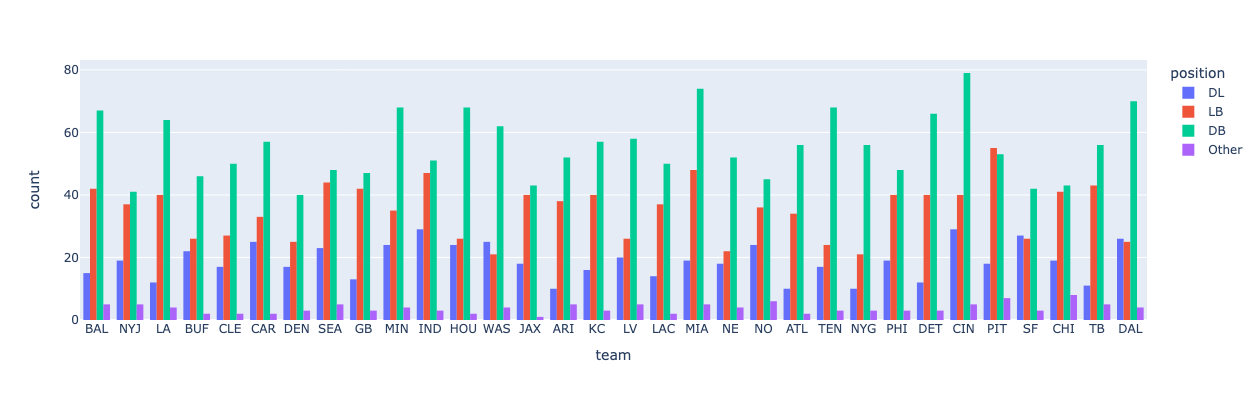

In [16]:
fig = px.histogram(df_solo_tackles, x="team",
             color='position', barmode='group', 
             height=400, category_orders=dict(position=["DL", "LB", "DB", "Other"]))
fig.show()

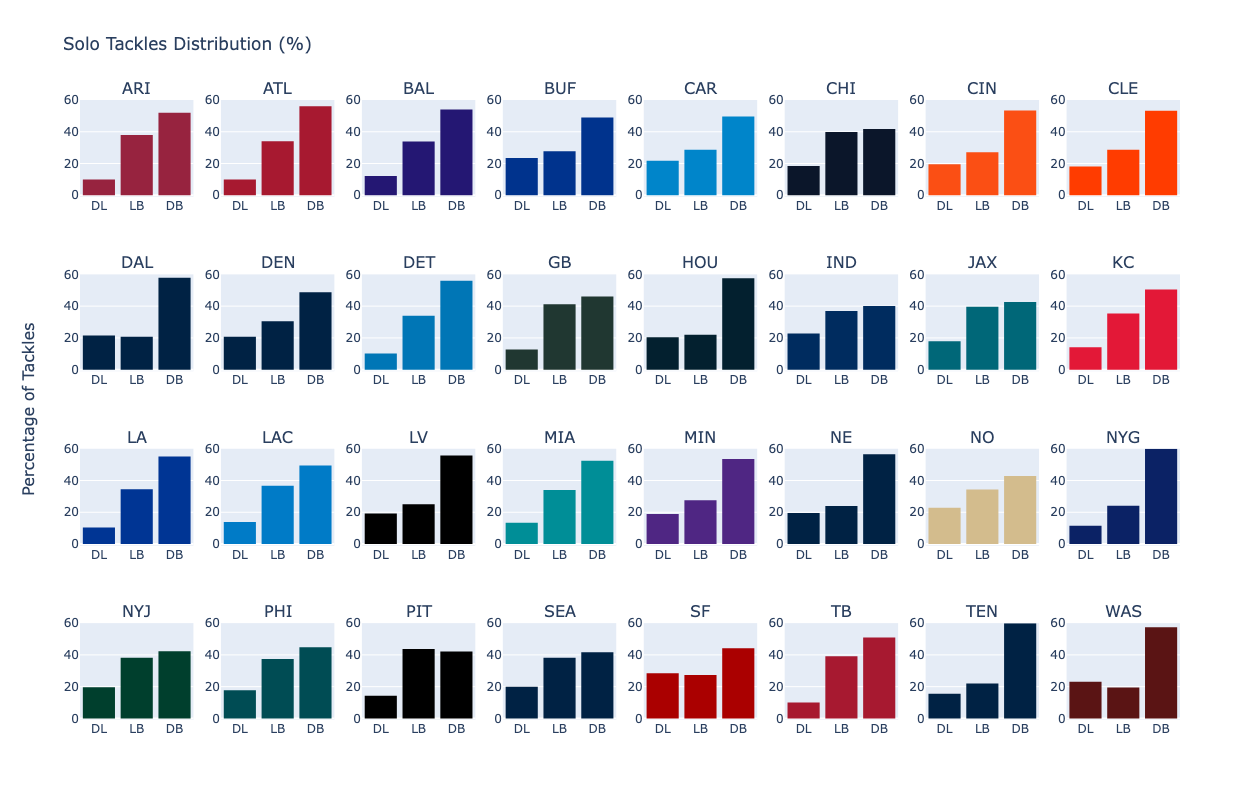

In [17]:
fig = make_subplots(rows=4, cols=8, y_title='Percentage of Tackles', subplot_titles=tuple(df_team_tackles['team'].values))

for i, team in enumerate(np.unique(df_solo_def['team'])):
    
    df_team = df_solo_def[df_solo_def['team']==team]
    df_team

    fig.add_trace(go.Histogram(
        x=df_team['position'],
        histnorm='percent',
        # name=team, # name used in legend and hover labels
        marker_color=df_team_tackles.loc[i,'team_color']
    ),row=math.floor(i/8)+1, col=i%8+1)
    
    fig.update_xaxes(row=math.floor(i/8)+1, col=i%8+1,
                     categoryorder='array', categoryarray= ["DL", "LB", "DB"])
                     # showticklabels=False)
        
    fig.update_yaxes(range=[-1, 60], row=math.floor(i/8)+1, col=i%8+1)
    
fig.update_layout(
    title_text='Solo Tackles Distribution (%)', # title of plot
    bargap=0.15, # gap between bars of adjacent location coordinates
    height=800,
    showlegend=False
)

fig.show()

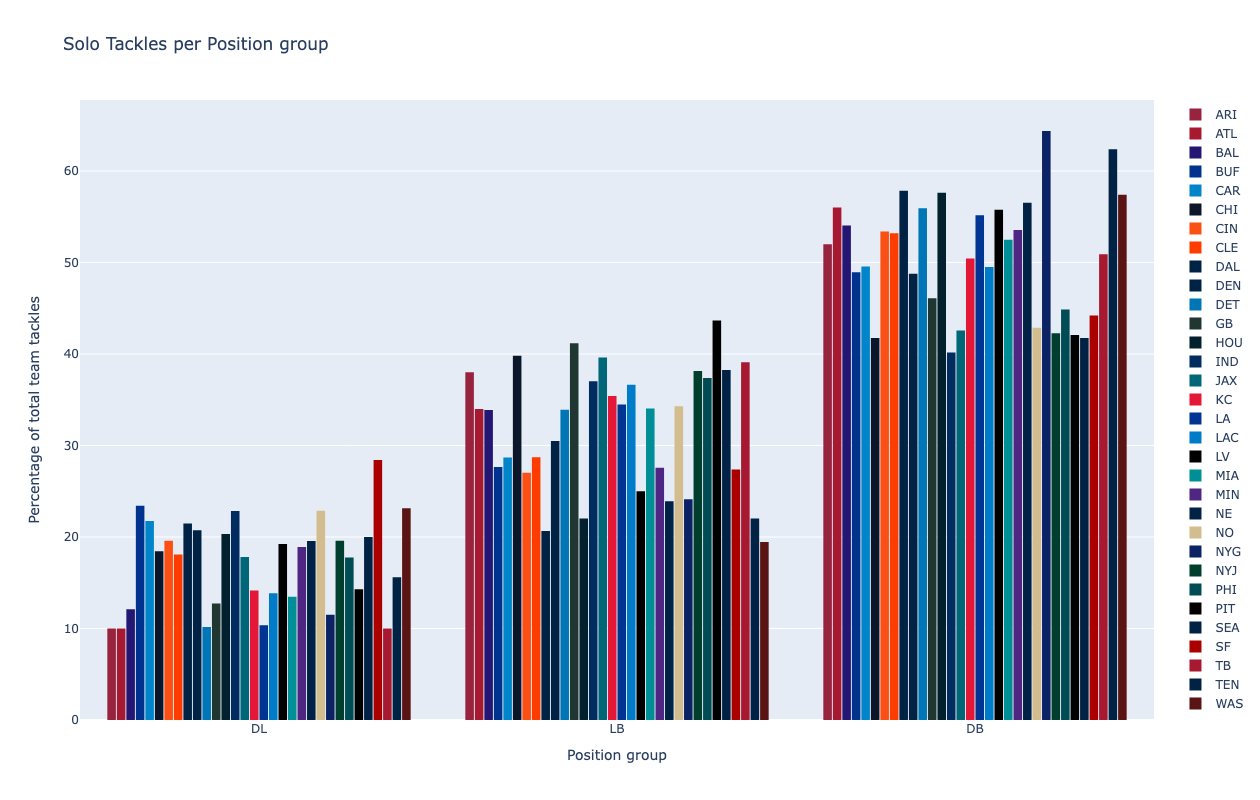

In [18]:
fig = go.Figure()

for i, team in enumerate(df_team_tackles['team'].values):
    df_team = df_solo_def[df_solo_def['team']==team]
    fig.add_trace(go.Histogram(
        x=df_team['position'],
        histnorm='percent',
        name=team, # name used in legend and hover labels
        marker_color=df_team_tackles.loc[i,'team_color']
    ))
    
fig.update_xaxes(categoryorder='array', categoryarray= ["DL", "LB", "DB"])
    
fig.update_layout(
    title_text='Solo Tackles per Position group', # title of plot
    xaxis_title_text='Position group', # xaxis label
    yaxis_title_text='Percentage of total team tackles', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=800
)

fig.show()

### Single team tackle distribution

In [19]:
team_code = 'BUF'
df_st_team = df_solo_def[df_solo_def['team']==team_code]

In [20]:
teamname = df_teams['team_name'][df_teams['team_abbr']==team_code].values[0]

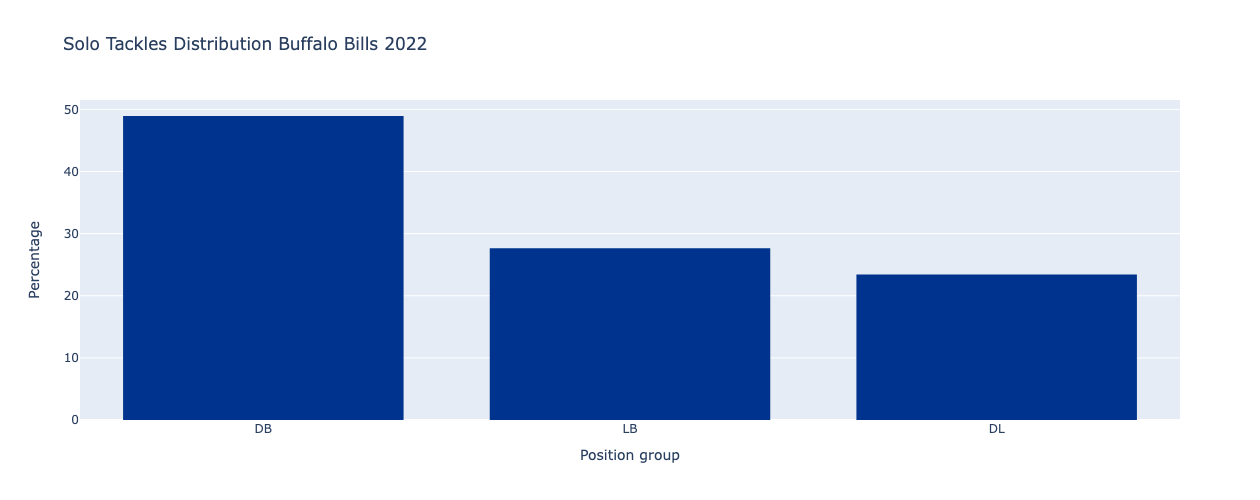

In [21]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_st_team['position'],
    histnorm='percent',
    # name=team, # name used in legend and hover labels
    marker_color=df_st_team['team_color'].values[0]
))

fig.update_xaxes(categoryorder='total descending')
    
fig.update_layout(
    title_text=f'Solo Tackles Distribution {teamname} {year}', # title of plot
    xaxis_title_text='Position group', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=500
)

fig.show()

In [22]:
top_tacklers = df_st_team.groupby('player_name')["position"].count().sort_values(ascending=False)

In [23]:
top_t_pos = []
top_t_pcent = []
for i, name in enumerate(top_tacklers.index.values.astype(str)):
    top_t_pos += [tuple(set(df_st_team.loc[df_st_team['player_name']==name,'position']))[0]]
    top_t_pcent += [top_tacklers[i]/np.sum(top_tacklers.values)]

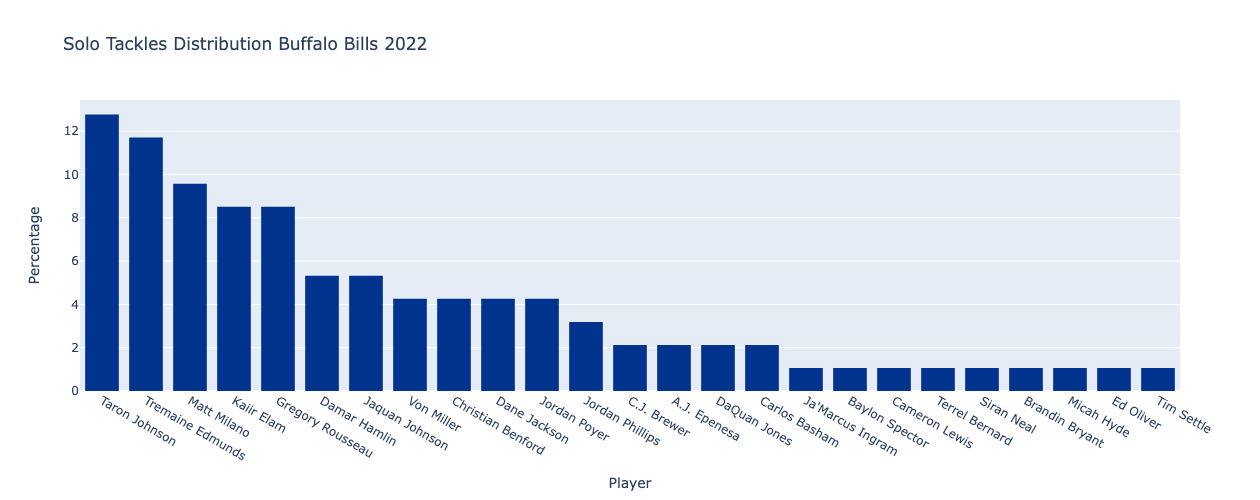

In [24]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_st_team['player_name'],
    histnorm='percent',
    # name=team, # name used in legend and hover labels
    marker_color=df_st_team['team_color'].values[0],
    hovertemplate =
    '<b>%{x}</b><extra></extra>' +
    '<br>'+
    '%{text}',
    text = [f'{np.round(j*100,2)} %<br>Position: <b>{i}<b>' for i,j in zip(top_t_pos, top_t_pcent)],
    texttemplate=' '
))

fig.update_xaxes(categoryorder='total descending')
    
fig.update_layout(
    title_text=f'Solo Tackles Distribution {teamname} {year}', # title of plot
    xaxis_title_text='Player', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=500
)

fig.show()

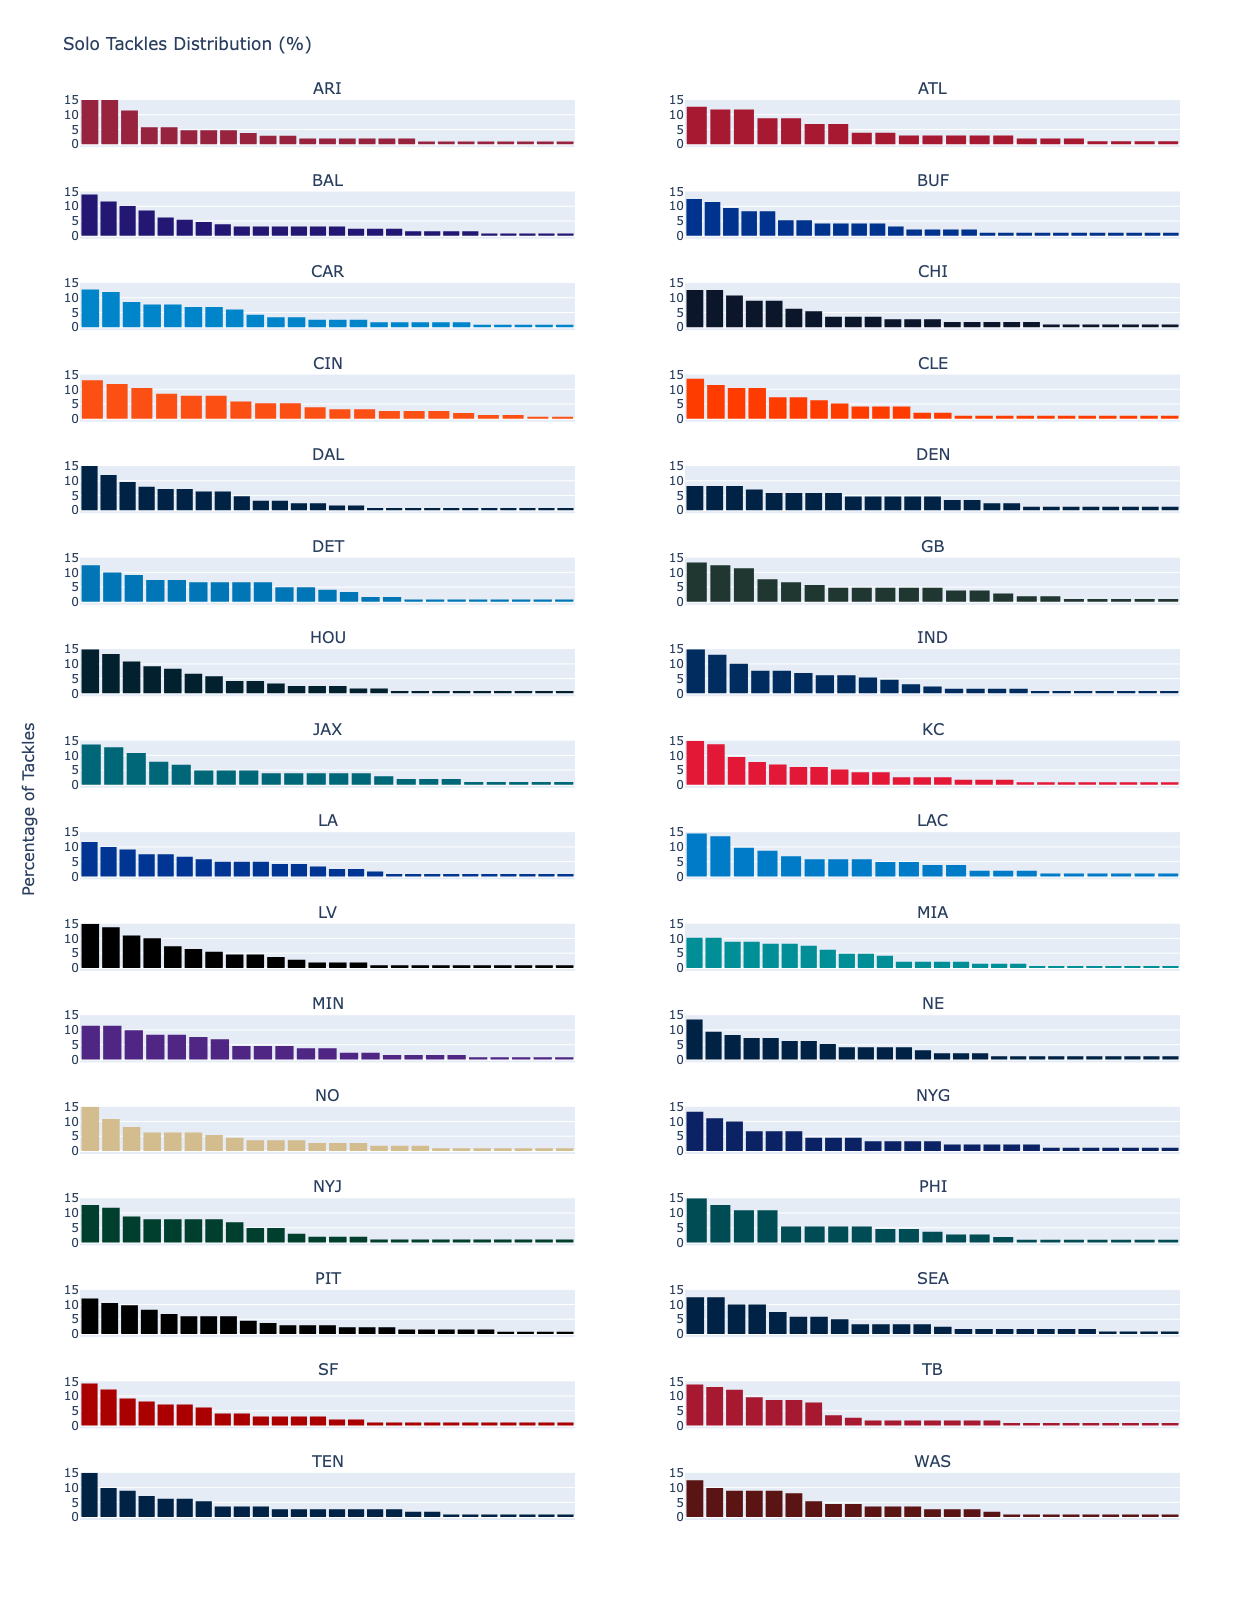

In [25]:
fig = make_subplots(rows=16, cols=2, y_title='Percentage of Tackles', subplot_titles=tuple(df_team_tackles['team'].values))

for i, team in enumerate(np.unique(df_solo_tackles['team'])):
        
    df_team = df_solo_tackles[df_solo_tackles['team']==team]
    
    top_tacklers = df_team.groupby('player_name')["position"].count().sort_values(ascending=False)
    
    top_t_pos = []
    top_t_pcent = []
    for j, name in enumerate(top_tacklers.index.values.astype(str)):
        top_t_pos += [tuple(set(df_team.loc[df_team['player_name']==name,'position']))[0]]
        top_t_pcent += [top_tacklers[j]/np.sum(top_tacklers.values)]

    fig.add_trace(go.Histogram( x=df_team['player_name'],
                                histnorm='percent',
                                # name=team, # name used in legend and hover labels
                                marker_color=df_team_tackles.loc[i,'team_color'],
                                hovertemplate = '<b>%{x}</b><extra></extra>' +
                                                '<br>'+
                                                '%{text}',
                                text = [f'{np.round(k*100,2)} %<br>Position: <b>{l}<b>' for k,l in zip(top_t_pcent, top_t_pos)],
                                texttemplate=' '),
                 row=math.floor(i/2)+1, col=i%2+1)
          
    
    fig.update_xaxes(row=math.floor(i/2)+1, col=i%2+1,
                     categoryorder='total descending',
                     showticklabels=False)
    fig.update_yaxes(range=[-1, 15], row=math.floor(i/2)+1, col=i%2+1)
    
fig.update_layout(
    title_text='Solo Tackles Distribution (%)', # title of plot
    bargap=0.15, # gap between bars of adjacent location coordinates
    height=1600,
    showlegend=False
)

fig.show()

### Versus the run

In [26]:
df_solo_tackles_run = df_pbp[np.logical_and(df_pbp['solo_tackle']==1.,df_pbp['play_type']=='run')]

In [27]:
df_solo_tackles_run = df_solo_tackles_run.merge(df_players[["player_id", "player_name", "position", "team"]], left_on="solo_tackle_1_player_id", right_on="player_id")
df_solo_tackles_run = df_solo_tackles_run.merge(df_teams[["team_abbr", "team_color"]], left_on="team", right_on="team_abbr")

In [28]:
df_solo_tackles_run.groupby('player_name')['player_name'].count().sort_values()

player_name
Samuel Womack       1
Patrick Surtain     1
Tony Fields         1
Darryl Johnson      1
Tommy Togiai        1
                   ..
Donovan Wilson     11
Talanoa Hufanga    11
Pete Werner        12
Bobby Okereke      12
Jonathan Owens     14
Name: player_name, Length: 512, dtype: int64

In [29]:
df_team_tackles_run = df_solo_tackles_run.groupby('team')['team'].count().reset_index(name='total_solo_tackles')
df_team_tackles_run = df_team_tackles_run.merge(df_teams[["team_abbr", "team_color"]], left_on="team", right_on="team_abbr")

## Tackles per position group

In [30]:
dl_tackles_run = np.count_nonzero(df_solo_tackles_run['position']=='DL')
lb_tackles_run = np.count_nonzero(df_solo_tackles_run['position']=='LB')
db_tackles_run = np.count_nonzero(df_solo_tackles_run['position']=='DB')

In [31]:
labels = ['DL','LB', 'DB']
values = [dl_tackles_run, lb_tackles_run, db_tackles_run]

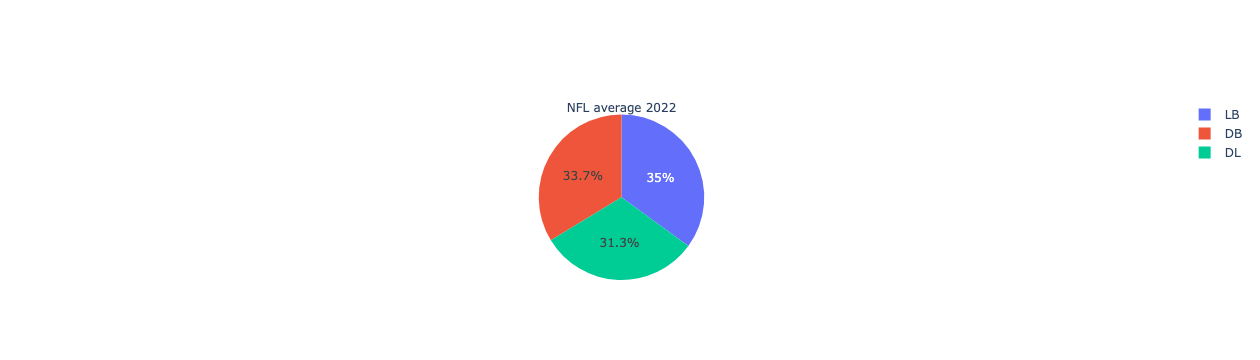

In [32]:
fig = go.Figure(data=[go.Pie(labels=labels, values=values, title=f'NFL average {year}')])
fig.show()

In [33]:
df_team_pos_run = df_solo_tackles_run.groupby(['team','position'])['position'].count()
df_pos_team_run = df_solo_tackles_run.groupby(['position','team'])['position'].count()

In [34]:
df_team_tackles_run = df_team_tackles_run.merge(df_pos_team_run['DB'].reset_index(name='DB_tackles'), on="team")
df_team_tackles_run = df_team_tackles_run.merge(df_pos_team_run['LB'].reset_index(name='LB_tackles'), on="team")
df_team_tackles_run = df_team_tackles_run.merge(df_pos_team_run['DL'].reset_index(name='DL_tackles'), on="team")

In [35]:
df_team_tackles_run.sort_values(by='DL_tackles')

team  total_solo_tackles team_abbr team_color  DB_tackles  LB_tackles  \
10  DET                  48       DET    #0076B6          22          19   
0   ARI                  37       ARI    #97233F          18          11   
1   ATL                  38       ATL    #A71930          16          14   
29   TB                  41        TB    #A71930          15          18   
16   LA                  37        LA    #003594          11          18   
25  PHI                  35       PHI    #004C54           9          16   
23  NYG                  39       NYG    #0B2265          18          11   
15   KC                  39        KC    #E31837          11          18   
7   CLE                  32       CLE    #FF3C00           8          14   
11   GB                  36        GB    #203731           9          16   
9   DEN                  26       DEN    #002244           9           4   
2   BAL                  42       BAL    #241773          11          19   
21   NE                  39        NE    #002244          18           9   
17  LAC                  39       LAC    #007BC7           7          20   
30  TEN                  44       TEN    #002244          23           7   
5   CHI                  55       CHI    #0B162A          15          25   
14  JAX                  37       JAX    #006778           8          14   
20  MIN                  51       MIN    #4F2683          18          17   
24  NYJ                  48       NYJ    #003F2D          12          20   
3   BUF                  40       BUF    #00338D          13          11   
12  HOU                  62       HOU    #03202F          32          14   
28   SF                  51        SF    #AA0000          18          16   
26  PIT                  58       PIT    #000000          13          28   
27  SEA                  58       SEA    #002244          22          19   
19  MIA                  53       MIA    #008E97          16          20   
31  WAS                  45       WAS    #5A1414          18          10   
18   LV                  43        LV    #000000          17           9   
4   CAR                  53       CAR    #0085CA          15          19   
8   DAL                  60       DAL    #002244          27          13   
22   NO                  57        NO    #D3BC8D          17          18   
6   CIN                  56       CIN    #FB4F14          17          17   
13  IND                  61       IND    #002C5F           9          27   

    DL_tackles  
10           7  
0            8  
1            8  
29           8  
16           8  
25          10  
23          10  
15          10  
7           10  
11          11  
9           12  
2           12  
21          12  
17          12  
30          14  
5           15  
14          15  
20          16  
24          16  
3           16  
12          16  
28          17  
26          17  
27          17  
19          17  
31          17  
18          17  
4           19  
8           20  
22          22  
6           22  
13          25

In [36]:
df_solo_tackles_run['position'].loc[~np.isin(df_solo_tackles_run['position'],['DL','LB','DB'])]='Other'

/var/folders/hh/2wq7ys4544ngb10v0y46_f_h0000gr/T/ipykernel_62007/3416953210.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Excluding offense or special teams players making tackles

In [37]:
df_solo_def_run = df_solo_tackles_run.loc[np.isin(df_solo_tackles_run['position'],['DL','LB','DB'])]

In [38]:
positions = tuple(set(df_solo_tackles_run['position']))

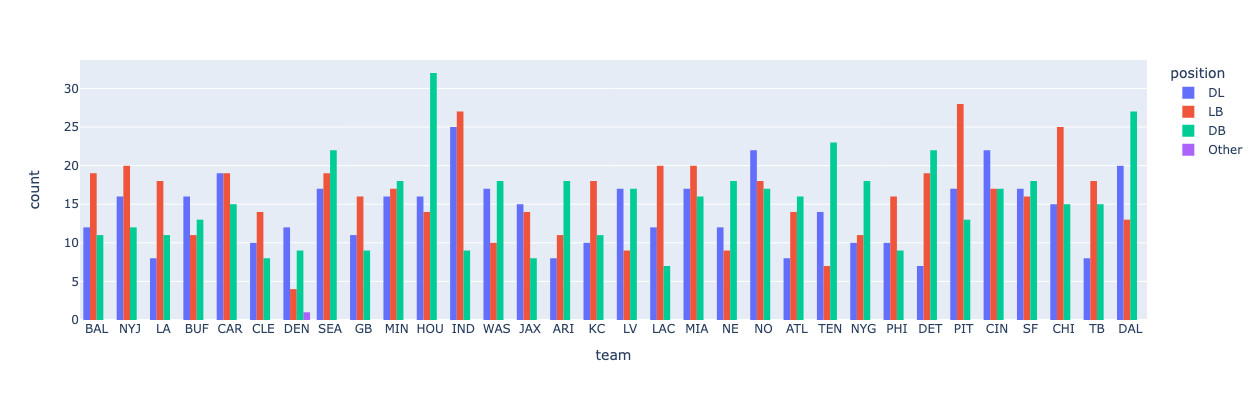

In [39]:
fig = px.histogram(df_solo_tackles_run, x="team",
             color='position', barmode='group', 
             height=400, category_orders=dict(position=["DL", "LB", "DB", "Other"]))
fig.show()

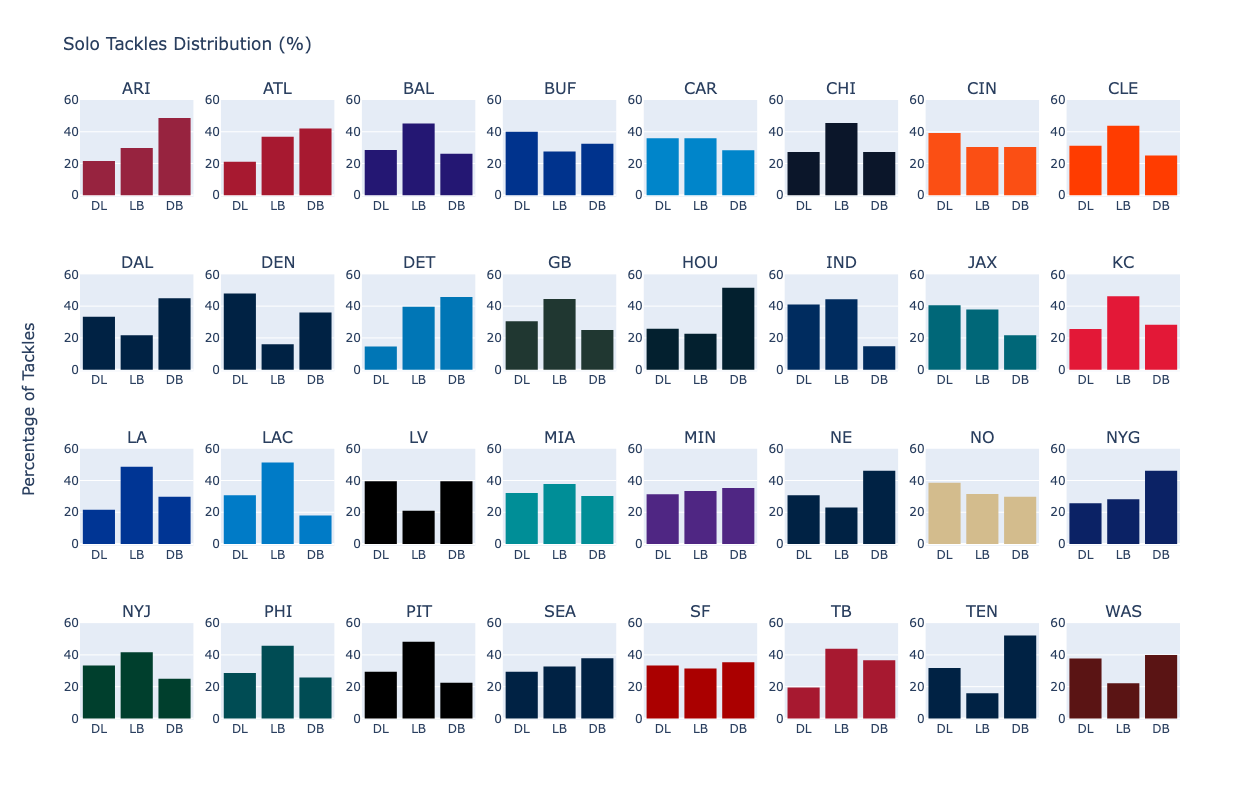

In [40]:
fig = make_subplots(rows=4, cols=8, y_title='Percentage of Tackles', subplot_titles=tuple(df_team_tackles_run['team'].values))

for i, team in enumerate(np.unique(df_solo_def_run['team'])):
    
    df_team_run = df_solo_def_run[df_solo_def_run['team']==team]

    fig.add_trace(go.Histogram(
        x=df_team_run['position'],
        histnorm='percent',
        # name=team, # name used in legend and hover labels
        marker_color=df_team_tackles_run.loc[i,'team_color']
    ),row=math.floor(i/8)+1, col=i%8+1)
    
    fig.update_xaxes(row=math.floor(i/8)+1, col=i%8+1,
                     categoryorder='array', categoryarray= ["DL", "LB", "DB"])
                     # showticklabels=False)
        
    fig.update_yaxes(range=[-1, 60], row=math.floor(i/8)+1, col=i%8+1)
    
fig.update_layout(
    title_text='Solo Tackles Distribution (%)', # title of plot
    bargap=0.15, # gap between bars of adjacent location coordinates
    height=800,
    showlegend=False
)

fig.show()

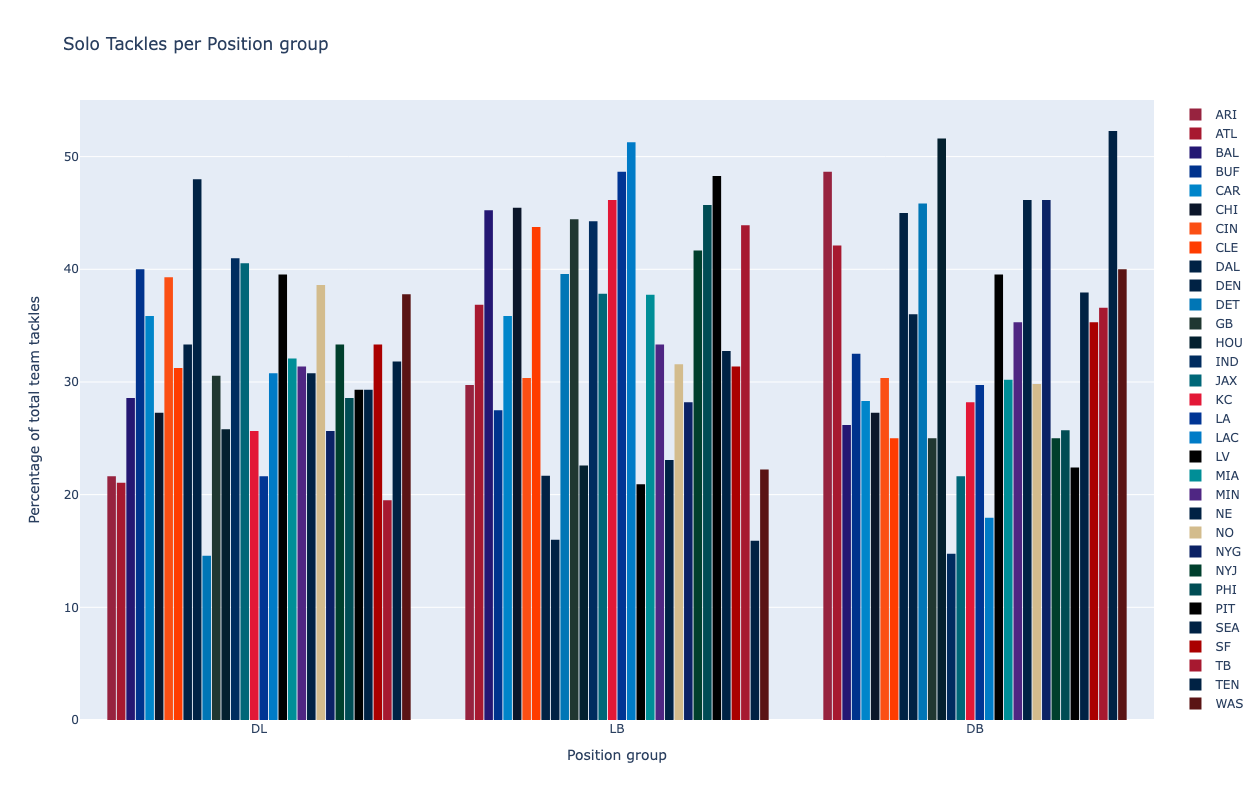

In [41]:
fig = go.Figure()

for i, team in enumerate(df_team_tackles_run['team'].values):
    df_team_run = df_solo_def_run[df_solo_def_run['team']==team]
    fig.add_trace(go.Histogram(
        x=df_team_run['position'],
        histnorm='percent',
        name=team, # name used in legend and hover labels
        marker_color=df_team_tackles_run.loc[i,'team_color']
    ))
    
fig.update_xaxes(categoryorder='array', categoryarray= ["DL", "LB", "DB"])
    
fig.update_layout(
    title_text='Solo Tackles per Position group', # title of plot
    xaxis_title_text='Position group', # xaxis label
    yaxis_title_text='Percentage of total team tackles', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=800
)

fig.show()

### Single team tackle distribution

In [42]:
team_code = 'BUF'
df_st_team_run = df_solo_def_run[df_solo_def_run['team']==team_code]

In [43]:
teamname = df_teams['team_name'][df_teams['team_abbr']==team_code].values[0]

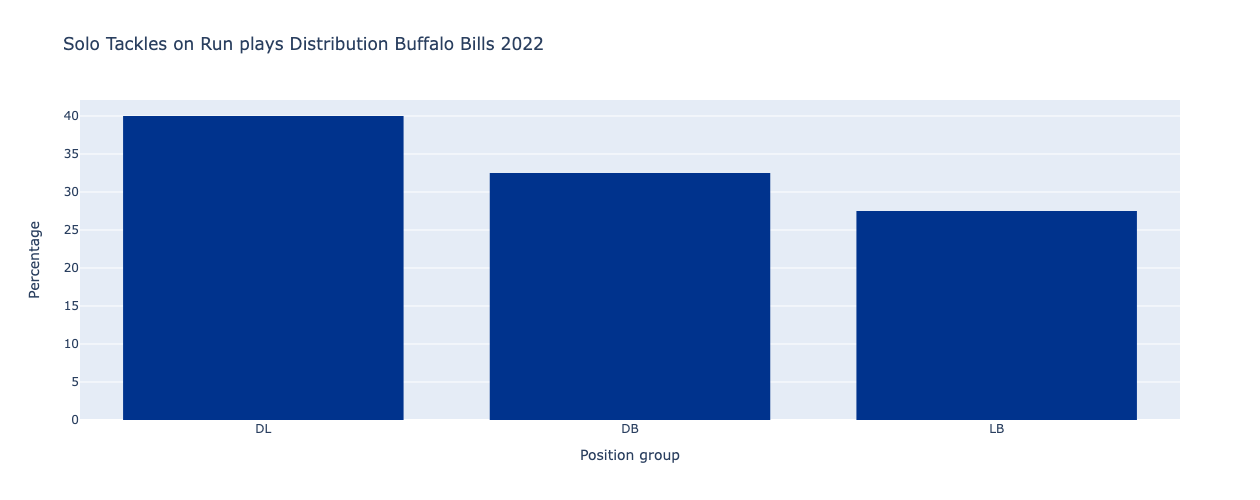

In [44]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_st_team_run['position'],
    histnorm='percent',
    # name=team, # name used in legend and hover labels
    marker_color=df_st_team_run['team_color'].values[0]
))

fig.update_xaxes(categoryorder='total descending')
    
fig.update_layout(
    title_text=f'Solo Tackles on Run plays Distribution {teamname} {year}', # title of plot
    xaxis_title_text='Position group', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=500
)

fig.show()

In [45]:
top_tacklers_run = df_st_team_run.groupby('player_name')["position"].count().sort_values(ascending=False)

In [46]:
top_t_pos = []
top_t_pcent = []
for i, name in enumerate(top_tacklers_run.index.values.astype(str)):
    top_t_pos += [tuple(set(df_st_team_run.loc[df_st_team_run['player_name']==name,'position']))[0]]
    top_t_pcent += [top_tacklers_run[i]/np.sum(top_tacklers_run.values)]

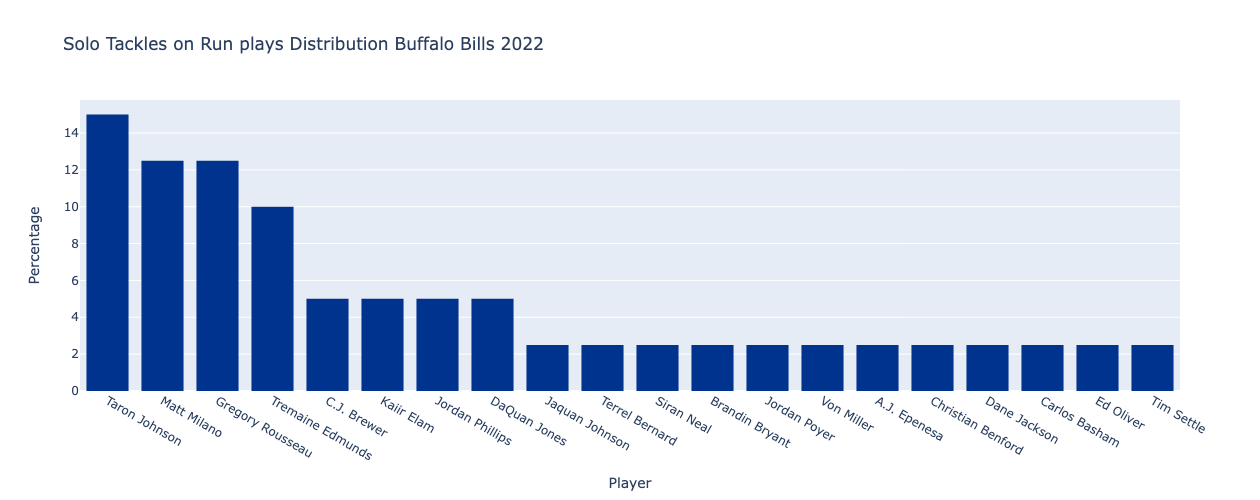

In [47]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_st_team_run['player_name'],
    histnorm='percent',
    # name=team, # name used in legend and hover labels
    marker_color=df_st_team_run['team_color'].values[0],
    hovertemplate =
    '<b>%{x}</b><extra></extra>' +
    '<br>'+
    '%{text}',
    text = [f'{np.round(j*100,2)} %<br>Position: <b>{i}<b>' for i,j in zip(top_t_pos, top_t_pcent)],
    texttemplate=' '
))

fig.update_xaxes(categoryorder='total descending')
    
fig.update_layout(
    title_text=f'Solo Tackles on Run plays Distribution {teamname} {year}', # title of plot
    xaxis_title_text='Player', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=500
)

fig.show()

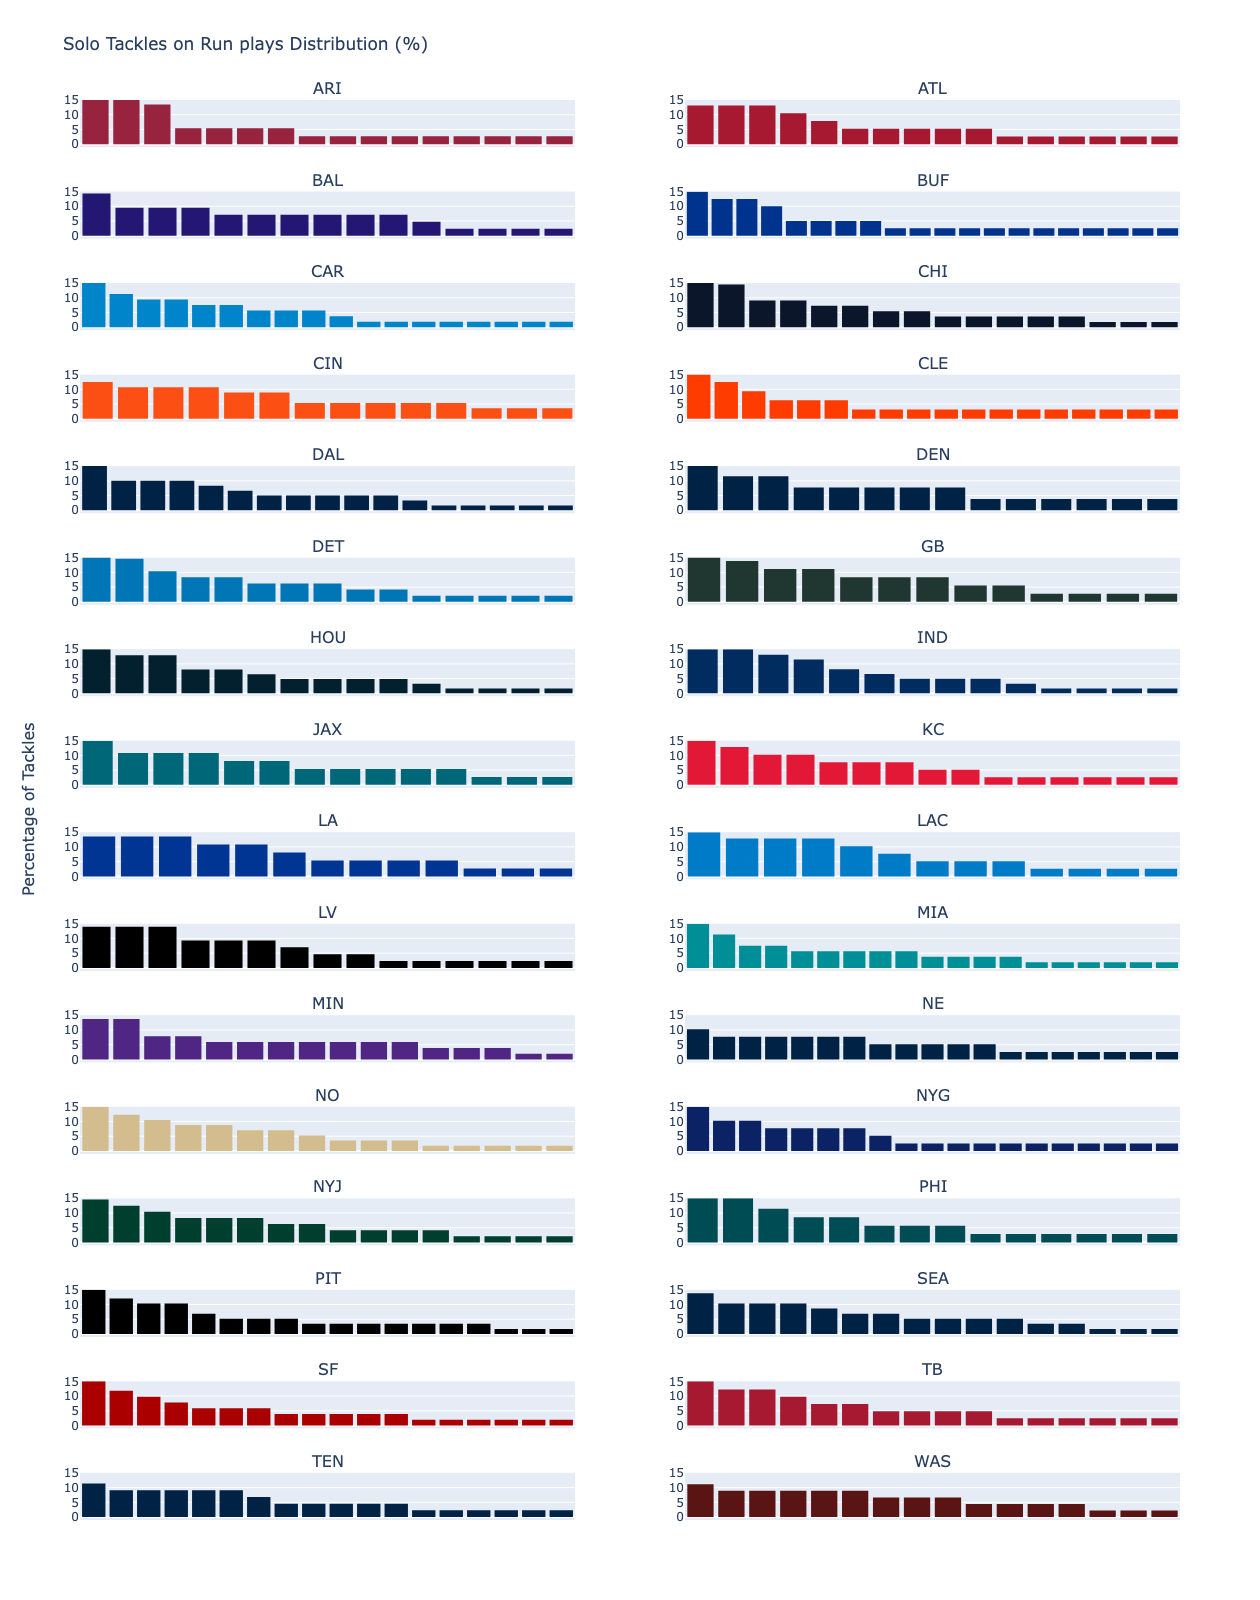

In [48]:
fig = make_subplots(rows=16, cols=2, y_title='Percentage of Tackles', subplot_titles=tuple(df_team_tackles_run['team'].values))

for i, team in enumerate(np.unique(df_solo_tackles['team'])):
        
    df_team_run = df_solo_tackles_run[df_solo_tackles_run['team']==team]
    
    top_tacklers_run = df_team_run.groupby('player_name')["position"].count().sort_values(ascending=False)
    
    top_t_pos = []
    top_t_pcent = []
    for j, name in enumerate(top_tacklers_run.index.values.astype(str)):
        top_t_pos += [tuple(set(df_team_run.loc[df_team_run['player_name']==name,'position']))[0]]
        top_t_pcent += [top_tacklers_run[j]/np.sum(top_tacklers_run.values)]

    fig.add_trace(go.Histogram( x=df_team_run['player_name'],
                                histnorm='percent',
                                # name=team, # name used in legend and hover labels
                                marker_color=df_team_tackles_run.loc[i,'team_color'],
                                hovertemplate = '<b>%{x}</b><extra></extra>' +
                                                '<br>'+
                                                '%{text}',
                                text = [f'{np.round(k*100,2)} %<br>Position: <b>{l}<b>' for k,l in zip(top_t_pcent, top_t_pos)],
                                texttemplate=' '),
                 row=math.floor(i/2)+1, col=i%2+1)
          
    
    fig.update_xaxes(row=math.floor(i/2)+1, col=i%2+1,
                     categoryorder='total descending',
                     showticklabels=False)
    fig.update_yaxes(range=[-1, 15], row=math.floor(i/2)+1, col=i%2+1)
    
fig.update_layout(
    title_text='Solo Tackles on Run plays Distribution (%)', # title of plot
    bargap=0.15, # gap between bars of adjacent location coordinates
    height=1600,
    showlegend=False
)

fig.show()